In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("")))))
from src.pre_process.V4.feature_add import FeatureAddition
from src.pre_process.V4.feature_duplicate import FeatureDuplication

In [3]:
BASE_PATH = r'C:\Users\com\Documents\GitHub\level2-competitiveds-recsys-06\data\etc'
data = pd.read_csv(os.path.join(BASE_PATH, 'v4_baek+recent+rank.csv'))
# train_data = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
# test_data = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

In [3]:
BASE_PATH = r'C:\Users\com\Documents\GitHub\level2-competitiveds-recsys-06\data\etc'
data = pd.read_csv('add_interest.csv')
sample_submission = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

---

# data 확인

In [4]:
data

,index,_type,area_price,area_m2_price,original_index,contract_year_month,contract_day,area_m2,contract_date_numeric,floor,...,apt_area_deposit_rank,recent_deposit,nearest_park_idx,nearest_school_idx,nearest_school_distance,park_area,before_1month_interest,before_2month_interest,before_3month_interest,interest_rate
0,0,train,658.914729,200.004471,0,201906,25,84.9981,20190625,9,...,29300,NaN,9759,6739,156.120431,3898.0,1.85,1.85,1.94,1.78
1,1,train,891.472868,270.594284,1,202003,26,84.9981,20200326,20,...,29300,17000.0,9759,6739,156.120431,3898.0,1.43,1.54,NaN,1.26
2,2,train,891.472868,270.594284,2,202003,28,84.9981,20200328,8,...,29300,23000.0,9759,6739,156.120431,3898.0,1.43,1.54,NaN,1.26
3,3,train,277.777778,84.260195,3,201907,15,59.3400,20190715,1,...,58901,NaN,9139,6535,214.559689,1616.0,1.78,1.85,1.85,1.68
4,4,train,99.447514,30.095302,4,201904,12,59.8100,20190412,6,...,58863,NaN,9201,6589,1708.489263,3986.0,1.94,1.92,1.99,1.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,test,NaN,NaN,150167,202402,27,115.5101,20240227,17,...,25360,37000.0,14160,9387,224.754177,8963.9,3.66,NaN,NaN,3.62
1951396,150168,test,NaN,NaN,150168,202403,2,142.8738,20240302,4,...,17911,43000.0,14160,9387,224.754177,8963.9,3.62,3.66,NaN,3.59
1951397,150169,test,NaN,NaN,150169,202403,16,142.8738,20240316,13,...,17911,43000.0,14160,9387,224.754177,8963.9,3.62,3.66,NaN,3.59
1951398,150170,test,NaN,NaN,150170,202403,22,114.9285,20240322,2,...,24128,32500.0,14160,9387,224.754177,8963.9,3.62,3.66,NaN,3.59


In [5]:
data.columns

Index(['index', '_type', 'area_price', 'area_m2_price', 'original_index',
       'contract_year_month', 'contract_day', 'area_m2',
       'contract_date_numeric', 'floor', 'built_year', 'latitude', 'longitude',
       'age', 'contract_0', 'contract_1', 'deposit', 'apt_idx', 'area',
       'grid_id', 'nearest_subway_distance', 'nearest_subway_idx',
       'nearest_park_distance', 'apt_deposit_rank', 'apt_area_deposit_rank',
       'recent_deposit', 'nearest_park_idx', 'nearest_school_idx',
       'nearest_school_distance', 'park_area', 'before_1month_interest',
       'before_2month_interest', 'before_3month_interest', 'interest_rate'],
      dtype='object')

---

# 추가 EDA

## 금리 데이터 활용

In [14]:
interest = pd.read_csv(os.path.join(BASE_PATH,'interestRate.csv'))

In [11]:
interest

,year_month,interest_rate
0,202405,3.56
1,202404,3.54
2,202403,3.59
3,202402,3.62
4,202401,3.66
...,...,...
61,201904,1.85
62,201903,1.94
63,201902,1.92
64,201901,1.99


In [12]:
data[['contract_year_month','deposit']]

,contract_year_month,deposit
0,201906,17000.0
1,202003,23000.0
2,202003,23000.0
3,201907,5000.0
4,201904,1800.0
...,...,...
1951395,202402,NaN
1951396,202403,NaN
1951397,202403,NaN
1951398,202403,NaN


In [21]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# tqdm 적용
tqdm.pandas()

# 전달 금리 정보를 'before_1month_interest' 피처로 추가
data['before_1month_interest'] = data['contract_year_month'].progress_apply(
    lambda x: interest[interest['year_month'] == (x - 1)]['interest_rate'].values[0]
    if (x - 1) in interest['year_month'].values else np.nan
)

100%|██████████| 1951400/1951400 [08:05<00:00, 4022.27it/s] 


In [23]:
# tqdm 적용
tqdm.pandas()

# 전달 금리 정보를 'before_2month_interest' 피처로 추가
data['before_2month_interest'] = data['contract_year_month'].progress_apply(
    lambda x: interest[interest['year_month'] == (x - 2)]['interest_rate'].values[0]
    if (x - 2) in interest['year_month'].values else np.nan
)

100%|██████████| 1951400/1951400 [07:22<00:00, 4409.93it/s] 


In [25]:
# tqdm 적용
tqdm.pandas()

# 전달 금리 정보를 'before_3month_interest' 피처로 추가
data['before_3month_interest'] = data['contract_year_month'].progress_apply(
    lambda x: interest[interest['year_month'] == (x - 3)]['interest_rate'].values[0]
    if (x - 3) in interest['year_month'].values else np.nan
    )

100%|██████████| 1951400/1951400 [06:32<00:00, 4969.22it/s] 


In [55]:
# 1. 데이터 병합 (contract_year_month와 year_month를 기준으로)
merged_data = pd.merge(data, interest, how='left', left_on='contract_year_month', right_on='year_month')

# 2. 필요 없어진 year_month 컬럼 제거 (선택사항)
data = merged_data.drop(columns=['year_month'])

In [56]:
data

,index,_type,area_price,area_m2_price,original_index,contract_year_month,contract_day,area_m2,contract_date_numeric,floor,...,apt_area_deposit_rank,recent_deposit,nearest_park_idx,nearest_school_idx,nearest_school_distance,park_area,before_1month_interest,before_2month_interest,before_3month_interest,interest_rate
0,0,train,658.914729,200.004471,0,201906,25,84.9981,20190625,9,...,29300,NaN,9759,6739,156.120431,3898.0,1.85,1.85,1.94,1.78
1,1,train,891.472868,270.594284,1,202003,26,84.9981,20200326,20,...,29300,17000.0,9759,6739,156.120431,3898.0,1.43,1.54,NaN,1.26
2,2,train,891.472868,270.594284,2,202003,28,84.9981,20200328,8,...,29300,23000.0,9759,6739,156.120431,3898.0,1.43,1.54,NaN,1.26
3,3,train,277.777778,84.260195,3,201907,15,59.3400,20190715,1,...,58901,NaN,9139,6535,214.559689,1616.0,1.78,1.85,1.85,1.68
4,4,train,99.447514,30.095302,4,201904,12,59.8100,20190412,6,...,58863,NaN,9201,6589,1708.489263,3986.0,1.94,1.92,1.99,1.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951395,150167,test,NaN,NaN,150167,202402,27,115.5101,20240227,17,...,25360,37000.0,14160,9387,224.754177,8963.9,3.66,NaN,NaN,3.62
1951396,150168,test,NaN,NaN,150168,202403,2,142.8738,20240302,4,...,17911,43000.0,14160,9387,224.754177,8963.9,3.62,3.66,NaN,3.59
1951397,150169,test,NaN,NaN,150169,202403,16,142.8738,20240316,13,...,17911,43000.0,14160,9387,224.754177,8963.9,3.62,3.66,NaN,3.59
1951398,150170,test,NaN,NaN,150170,202403,22,114.9285,20240322,2,...,24128,32500.0,14160,9387,224.754177,8963.9,3.62,3.66,NaN,3.59


In [15]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# tqdm 적용
tqdm.pandas()

# 전달 금리 정보를 'before_4month_interest' 피처로 추가
data['before_4month_interest'] = data['contract_year_month'].progress_apply(
    lambda x: interest[interest['year_month'] == (x - 4)]['interest_rate'].values[0]
    if (x - 4) in interest['year_month'].values else np.nan
)

100%|██████████| 1951400/1951400 [05:57<00:00, 5451.67it/s] 


In [17]:
# tqdm 적용
tqdm.pandas()

# 전달 금리 정보를 'before_5month_interest' 피처로 추가
data['before_5month_interest'] = data['contract_year_month'].progress_apply(
    lambda x: interest[interest['year_month'] == (x - 5)]['interest_rate'].values[0]
    if (x - 5) in interest['year_month'].values else np.nan)

100%|██████████| 1951400/1951400 [05:02<00:00, 6441.32it/s] 


In [18]:
# tqdm 적용
tqdm.pandas()

# 전달 금리 정보를 'before_6month_interest' 피처로 추가
data['before_6month_interest'] = data['contract_year_month'].progress_apply(
    lambda x: interest[interest['year_month'] == (x - 6)]['interest_rate'].values[0]
    if (x - 6) in interest['year_month'].values else np.nan)

100%|██████████| 1951400/1951400 [04:22<00:00, 7440.82it/s] 


## test data의 apt_idx 데이터만 학습

In [31]:
# 1. 데이터프레임을 _type을 기준으로 train과 test로 나눔
train_data = data[data['_type'] == 'train']
test_data = data[data['_type'] == 'test']

# 2. test 데이터의 apt_idx 리스트 추출
test_apt_idx = test_data['apt_idx'].unique()

In [34]:
len(test_apt_idx)

11885

In [35]:
# 3. train 데이터에서 test 데이터의 apt_idx와 일치하는 것들만 필터링
filtered_train_data = train_data[train_data['apt_idx'].isin(test_apt_idx)]

In [36]:
filtered_train_data

,index,_type,area_price,area_m2_price,original_index,contract_year_month,contract_day,area_m2,contract_date_numeric,floor,...,apt_deposit_rank,apt_area_deposit_rank,recent_deposit,nearest_park_idx,nearest_school_idx,nearest_school_distance,park_area,before_1month_interest,before_2month_interest,before_3month_interest
0,0,train,658.914729,200.004471,0,201906,25,84.9981,20190625,9,...,7683,29300,NaN,9759,6739,156.120431,3898.0,1.85,1.85,1.94
1,1,train,891.472868,270.594284,1,202003,26,84.9981,20200326,20,...,7683,29300,17000.0,9759,6739,156.120431,3898.0,1.43,1.54,NaN
2,2,train,891.472868,270.594284,2,202003,28,84.9981,20200328,8,...,7683,29300,23000.0,9759,6739,156.120431,3898.0,1.43,1.54,NaN
5,5,train,778.210117,235.476404,5,201904,26,84.9342,20190426,13,...,11986,43564,NaN,9150,6535,779.057020,4858.3,1.94,1.92,1.99
6,6,train,336.134454,101.858925,6,201905,7,39.2700,20190507,3,...,18382,59031,NaN,9117,6515,808.416163,6173.0,1.85,1.94,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,1801223,train,1120.689655,339.683972,1801223,202311,25,114.8126,20231125,5,...,6088,24139,33000.0,14160,9387,224.754177,8963.9,3.97,3.82,3.66
1801224,1801224,train,1229.773463,372.882420,1801224,202311,28,101.9088,20231128,6,...,6088,25333,35000.0,14160,9387,224.754177,8963.9,3.97,3.82,3.66
1801225,1801225,train,1063.218391,322.327729,1801225,202312,3,114.7900,20231203,19,...,6088,27351,29000.0,14160,9387,224.754177,8963.9,4.00,3.97,3.82
1801226,1801226,train,1113.268608,337.556717,1801226,202312,4,101.9088,20231204,15,...,6088,25333,38000.0,14160,9387,224.754177,8963.9,4.00,3.97,3.82


## datatime 변환

In [6]:
import time
from datetime import datetime

# 1. 'contract_date_numeric'을 datetime 형식으로 변환 (YYMMDD 형식 가정)
# 예시: 230212 -> 2023-02-12
data['contract_date'] = pd.to_datetime(data['contract_date_numeric'], format='%Y%m%d')

# 2. time.mktime()을 사용하여 타임스탬프 변환
data['contract_timestamp'] = data['contract_date'].apply(lambda x: int(time.mktime(x.timetuple())))

# 결과 확인
print(data[['contract_date_numeric', 'contract_date', 'contract_timestamp']].head())

   contract_date_numeric contract_date  contract_timestamp
0               20190625    2019-06-25          1561388400
1               20200326    2020-03-26          1585148400
2               20200328    2020-03-28          1585321200
3               20190715    2019-07-15          1563116400
4               20190412    2019-04-12          1554994800


## 데이터 컬럼 확인

In [7]:
data.columns

Index(['index', '_type', 'area_price', 'area_m2_price', 'original_index',
       'contract_year_month', 'contract_day', 'area_m2',
       'contract_date_numeric', 'floor', 'built_year', 'latitude', 'longitude',
       'age', 'contract_0', 'contract_1', 'deposit', 'apt_idx', 'area',
       'grid_id', 'nearest_subway_distance', 'nearest_subway_idx',
       'nearest_park_distance', 'apt_deposit_rank', 'apt_area_deposit_rank',
       'recent_deposit', 'nearest_park_idx', 'nearest_school_idx',
       'nearest_school_distance', 'park_area', 'before_1month_interest',
       'before_2month_interest', 'before_3month_interest', 'interest_rate',
       'contract_date', 'contract_timestamp'],
      dtype='object')

---

# 모델링

In [8]:
train_data = data[data['_type'] == 'train']
test_data = data[data['_type'] == 'test']

In [9]:
column_needed = [
    # 'index', '_type', 'area_price', 'area_m2_price', 'original_index','contract_year_month', 'contract_day', 'area_m2',
    # 'contract_date_numeric', 
    'area_m2',
    'floor', 'built_year', 'latitude', 'longitude','age', 
    'contract_0', 'contract_1', 
    'deposit', 
    'apt_idx', 
    'area',
    'grid_id', 
    'nearest_subway_distance', 
    'nearest_subway_idx',
    'nearest_park_distance',
    'apt_deposit_rank', 'apt_area_deposit_rank',
    'recent_deposit', 
    'nearest_park_idx', 
    'nearest_school_idx',
    'nearest_school_distance',
    'park_area',
    'contract_timestamp',
    # 'before_1month_interest',
    # 'before_2month_interest', 'before_3month_interest',
    # 'before_4month_interest', 'before_5month_interest','before_6month_interest',
    # 'interest_rate',
]
test_column_needed = [
    # 'index', '_type', 'area_price', 'area_m2_price', 'original_index','contract_year_month', 'contract_day', 'area_m2',
    # 'contract_date_numeric', 
    'area_m2',
    'floor', 'built_year', 'latitude', 'longitude','age', 
    'contract_0', 'contract_1',  
    'apt_idx', 
    'area',
    'grid_id', 
    'nearest_subway_distance', 
    'nearest_subway_idx',
    'nearest_park_distance',
    'apt_deposit_rank', 'apt_area_deposit_rank',
    'recent_deposit', 
    'nearest_park_idx', 
    'nearest_school_idx',
    'nearest_school_distance',
    'park_area',
    'contract_timestamp',
    # 'before_1month_interest',
    # 'before_2month_interest', 'before_3month_interest',
    # 'before_4month_interest', 'before_5month_interest','before_6month_interest',
    # 'interest_rate',
]
train_df = train_data[column_needed]
test_df = test_data[test_column_needed]

In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# # 학습에 사용할 특징 열
# feature_columns = [col for col in data.columns if col not in ['deposit', '_type', 'index']]
# 학습 및 테스트 데이터 준비
X_train = train_df.drop(columns=['deposit'])
y_train = train_df['deposit']
X_test = test_df.copy()
# 학습 데이터를 검증용으로 분할
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2,
                                                                          random_state=42)
# XGBoost를 위한 DMatrix 생성
dtrain = xgb.DMatrix(X_train_split, label=y_train_split)
dval = xgb.DMatrix(X_val_split, label=y_val_split)
dtest = xgb.DMatrix(X_test)
# XGBoost 파라미터 설정
params = {
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mae',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}
# 모델 학습
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(params, dtrain, num_boost_round=500, early_stopping_rounds=50, evals=evals, verbose_eval=10)
# 테스트 세트에 대한 예측
y_pred = model.predict(dtest)

[0]	train-mae:16477.58305	eval-mae:16479.55502
[10]	train-mae:11132.73939	eval-mae:11139.07682
[20]	train-mae:7976.41419	eval-mae:7977.26888
[30]	train-mae:6213.37309	eval-mae:6207.68317
[40]	train-mae:5240.88292	eval-mae:5232.57045
[50]	train-mae:4732.40899	eval-mae:4724.13715
[60]	train-mae:4487.00785	eval-mae:4480.41348
[70]	train-mae:4350.44049	eval-mae:4345.95463
[80]	train-mae:4278.13600	eval-mae:4275.52320
[90]	train-mae:4229.79867	eval-mae:4228.13980
[100]	train-mae:4199.03937	eval-mae:4198.47045
[110]	train-mae:4173.09698	eval-mae:4173.66333
[120]	train-mae:4154.25522	eval-mae:4155.63682
[130]	train-mae:4130.78370	eval-mae:4132.95754
[140]	train-mae:4112.47802	eval-mae:4115.10880
[150]	train-mae:4092.77440	eval-mae:4096.01843
[160]	train-mae:4080.45950	eval-mae:4084.13522
[170]	train-mae:4068.61414	eval-mae:4073.03082
[180]	train-mae:4052.41535	eval-mae:4057.75574
[190]	train-mae:4041.24790	eval-mae:4047.05091
[200]	train-mae:4028.23159	eval-mae:4034.86304
[210]	train-mae:4018

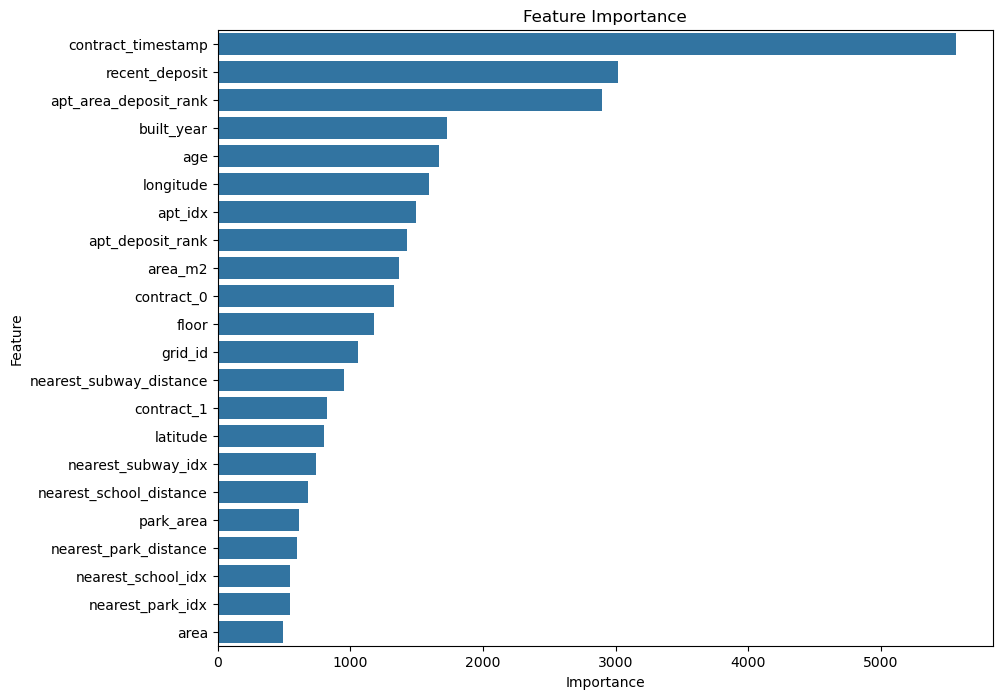

In [11]:
#Feature Importance
# 피처 중요도 추출
feature_importance = model.get_fscore()
# 피처 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame(feature_importance.items(), columns=['Feature', 'Importance'])
# 중요도 순으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

In [12]:
y_pred

array([22421.098 ,  7492.2866,  6606.265 , ..., 44921.76  , 36558.863 ,
       37662.98  ], dtype=float32)

In [13]:
sample_submission['deposit'] = y_pred
sample_submission

,index,deposit
0,0,22421.097656
1,1,7492.286621
2,2,6606.265137
3,3,6762.756836
4,4,6808.089844
...,...,...
150167,150167,37214.171875
150168,150168,43288.894531
150169,150169,44921.761719
150170,150170,36558.863281


In [14]:
sample_submission.describe()

,index,deposit
count,150172.00000,150172.000000
mean,75085.50000,39086.136719
std,43351.06665,23920.511719
min,0.00000,3228.621582
25%,37542.75000,23182.177734
50%,75085.50000,33847.093750
75%,112628.25000,48574.312500
max,150171.00000,363064.125000


In [39]:
sample_submission.to_csv('v8_add(interest+1month).csv', index=False)

---